<h1>An simple audio classifier based on MFCC features</h1>

This notebook shows how to build a simple audio classifier using MFCC features. 

**Why MFCC?**

MFCC are a good starting point when building an audio classifier designed to distinguish between audio recordings based on their **timbre**, since they provide a compact representation of the spectral envelope. Examples of audio classses that are well characterized by their timbre include musical instruments (e.g. trumpet vs. piano) or urban environmental sounds (e.g. siren vs. car honk vs. and jackhammer).

However, it is important to bear in mind that not all audio-related classification tasks are timbre-related. For example, you might be interested in identifying (classifiying) the chords played in a music recording. What makes one chord different from another is **not its timbre**: the same chord can be played by different instruments with different timbres and it will still be the same chord. What makes chords different (among other factors) are the notes (pitches) they contain. Thus, a more suitable class of features for chord classification would be [chroma features](https://en.wikipedia.org/wiki/Chroma_feature).

Since in this example we want to distinguish between two broad musical styles (genres), which (usually) have fairly different instrumentations (and hence timbre), MFCC are probably a good choice for the task.

**IMPORTANT**: This example makes a couple of assumptions:

1. All the audio files have been preprocessed to ensure they are in the same format: single channel (mono) with a sample rate of 44100 Hz and a bit depth of 16 in wav format. If you haven't preprocessed your audio, consult the **```convert_audio_format```** notebook in this repository. Working with audio files in different formats can lead to unexpected (=undesired!) results.

2. The class label of each audio file has been added to the filename as a prefix followed by an underscore ('_'). This was accomplished using the **```rename_files_prefix```** notebook in this repository. This makes it easy to get the class label directly from each file. Some datasets (such as UrbanSound8K) provide a mapping from filename to class label in a metadata file, in which case this example would have to be modified so that the class label is looked up in the metadata file rather than obtained from the filename.

Dependencies:
* numpy: http://www.numpy.org/
* scikit-learn: http://scikit-learn.org/
* librosa: http://librosa.github.io/librosa/
* matplotlib: http://matplotlib.org/

In [1]:
# Load the modules we're going to need
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import os
import glob
import librosa
from IPython.display import Audio

<h2>Step 0: Compiling your dataset</h2>

For creating this example I've used a collection of short audio snippets (30 seconds each) from two broad music categories: "classical" and "rock". All the files have been preprocessed using the ```convert_audio_format``` and ```rename_files_predix``` notebooks, and then divided into a train and test folder. There are 109 files in the train folder and 20 files in the test folder.

Since we will use different files in class (your music!), the results displayed in this notebook will be different when we run it in class.

<h2>Step 1: Data cleaning</h2>

As noted above, this notebook assumes data cleaning has already been performed: all files are in the same format (single channel [mono], 16-bit depth, 44100 sample rate, wav), and the class label of each file is indicated as a prefix followed by an underscore in the filename.

In [2]:
# We've previously preprocessed our data and coverted all files to a sample rate of 44100
samplerate = 44100

<h2>Step 2: Feature extraction</h2>

In [3]:
# Specify where the audio files for training and testing reside
train_folder = '/Users/justin/Documents/courses/NYU/MIR/mfcc_classifier/2016/mir_class_train'
test_folder = '/Users/justin/Documents/courses/NYU/MIR/mfcc_classifier/2016/mir_class_test'

# Get a list of all the training audio files (must be .WAV files)
train_files = glob.glob(os.path.join(train_folder, '*.wav'))

# Get a list of all the test audio files (must be .WAV files)
test_files = glob.glob(os.path.join(test_folder, '*.wav'))

# Specify the labels (classes) we're going to classify the data into
label0 = 'classical'
label1 = 'rock'
labels = [label0, label1]

We're going to compute MFCC features using 40 mel bands, 40 DCT coefficients, keeping the bottom 13 MFCC coefficients after skipping the first coefficient (i.e. keep MFCC coefficieints 1-13, discard coefficients 0 and 14-39).

For every file we will summarize the time-series obtained for each coefficient using 2 summary statistics: mean and standard deviation.

Before training (and testing), we are also going to standardize our features across each dimension (this is particularly important if you plan to use an SVM classifier for some kernel functions).

**Tip 1**: we might be able to obtain better clasification by adding more features to our feature vector. For example, we could compute the delta (first derivative) of each MFCC coefficient time-series (```np.diff(mfcc)```) and compute summary statistics from this time series as well. We could even do the same for the delta-delta (second derivative). Another option would be to add more summary statistics such as the minimum, maximum, median, or higher-order moments such as skewness and kurtosis. Be careful though: if the dimensionality of your featue vector is too high you run the risk of overfitting your data, especially if your dataset is small!

**Tip 2**: since the train/test sets used in this example are relatively small, and since we're only going to run through this example once, the features are computed on the fly in memory. If, however, you are working with a larger dataset (e.g. UrbanSound8K), feature extraction can take a considerable time. In this case, it's a good idea to store the features to disk, so that you can experiment with different classification models and classifier hyper-parameters without having to re-compute the features every time.

Lets start by defining the parameters of our MFCC features: 
* window (frame) size
* hop size
* number of mel bands (the number of DCT coefficients will be the same in this implementation) 
* number of MFCC coefficients to keep: 

In [4]:
window_size = 2048
hop_size = 512
n_bands = 40
n_mfcc = 13

Now we'll extract features from the training set:

In [5]:
# Define lists to store the training features and corresponding training labels
train_features = []
train_labels = []

# For every audio file in the training set, load the file, compute MFCCs, summarize them over time
# using the mean and standard deviation (for each MFCC coefficient), and then save the features
# and corresponding label in the designated lists
for tf in train_files:
    
    print("filename: {:s}".format(os.path.basename(tf)))
    
    # Load audio
    audio, sr = librosa.load(tf, sr=samplerate, mono=True)

    # Extract mfcc coefficients (remember we will discard the first one)
    # To see all the relevant kwarg arugments consult the documentation for
    # librosa.feature.mfcc, librosa.feature.melspectrogram and librosa.filters.mel
    mfcc = librosa.feature.mfcc(audio, sr=sr, n_fft=window_size, hop_length=hop_size,
                                fmax=samplerate/2, n_mels=n_bands, n_mfcc=(n_mfcc + 1))
          
    # Discard the first coefficient
    mfcc = mfcc[1:,:]
    print("mfcc matrix shape: {:s}".format(mfcc.shape))
    
    # Summarize the time-series (per-frame values) for each mfcc coefficient:
    # Hint: we could also compute these statistics on the delta and delta-delta
    # time series. We could also compute more statistics from each time series!
    mfcc_means = np.mean(mfcc, 1)
    mfcc_stddevs = np.std(mfcc, 1)
    
    # We could do the same for the delta features like this:
    # mfcc_d1_means = np.mean(np.diff(mfcc), 1)
    # mfcc_d1_stddevs = np.std(np.diff(mfcc), 1)
    
    # Concatenate means and std. dev's into a single feature vector
    feature_vector = np.concatenate((mfcc_means, mfcc_stddevs), axis=0)
    print("feature vector shape: {:s}".format(feature_vector.shape))
    
    # Get label for audio file from its filename and convert to integer based on 
    # its location in the label list defined at the beginning of Step 2
    tf_label = os.path.basename(tf).split('_')[0]
    tf_label_ind = labels.index(tf_label)
    print("file label: {:d}".format(tf_label_ind))
    
    # Store the feature vector and corresponding label in integer format
    train_features.append(feature_vector)
    train_labels.append(tf_label_ind)
    print(" ")

filename: classical_30s_Bach - Air - Best-of Classical Music.wav.wav
mfcc matrix shape: (13, 2596)
feature vector shape: (26,)
file label: 0
 
filename: classical_30s_Greig - In the hall of the mountain king - Best-of Classical Music.wav.wav
mfcc matrix shape: (13, 2629)
feature vector shape: (26,)
file label: 0
 
filename: classical_30s_Händel - Ombra Mai Fu - Best-of Classical Music.wav.wav
mfcc matrix shape: (13, 2621)
feature vector shape: (26,)
file label: 0
 
filename: classical_30s_Mozart - Piano Sonata No. 14 in C minor, K. 457.wav.wav
mfcc matrix shape: (13, 2888)
feature vector shape: (26,)
file label: 0
 
filename: classical_30s_Ponchielli - Hours Dance - Best-of Classical Music.wav.wav
mfcc matrix shape: (13, 2692)
feature vector shape: (26,)
file label: 0
 
filename: classical_30s_Tchaikovsky - Piano Concerto No 1, B Flat Minor, Op 23 open - Best-of Classical Music.wav.wav
mfcc matrix shape: (13, 2622)
feature vector shape: (26,)
file label: 0
 
filename: classical_Beetho

Next, do do the same for the test data (of course we must extact exactly the same features for the training and test sets):

In [6]:
# Define lists to store the test features and corresponding test labels
test_features = []
test_labels = []

# For every audio file in the training set, load the file, compute MFCCs, summarize them over time
# using the mean and standard deviation (for each MFCC coefficient), and then save the features
# and corresponding label in the designated lists
for tf in test_files:
    
    print("filename: {:s}".format(os.path.basename(tf)))
    
    # Load audio
    audio, sr = librosa.load(tf, sr=samplerate, mono=True)

    # Extract mfcc coefficients (remember we will discard the first one)
    # To see all the relevant kwarg arugments consult the documentation for
    # librosa.feature.mfcc, librosa.feature.melspectrogram and librosa.filters.mel
    mfcc = librosa.feature.mfcc(audio, sr=sr, n_fft=window_size, hop_length=hop_size,
                                fmax=samplerate/2, n_mels=n_bands, n_mfcc=(n_mfcc + 1))
          
    # Discard the first coefficient
    mfcc = mfcc[1:,:]
    print("mfcc matrix shape: {:s}".format(mfcc.shape))
    
    # Summarize the time-series (per-frame values) for each mfcc coefficient:
    # Hint: we could also compute these statistics on the delta and delta-delta
    # time series. We could also compute more statistics from each time series!
    mfcc_means = np.mean(mfcc, 1)
    mfcc_stddevs = np.std(mfcc, 1)
    
    # We could do the same for the delta features like this:
    # mfcc_d1_means = np.mean(np.diff(mfcc), 1)
    # mfcc_d1_stddevs = np.std(np.diff(mfcc), 1)
    
    # Concatenate means and std. dev's into a single feature vector
    feature_vector = np.concatenate((mfcc_means, mfcc_stddevs), axis=0)
    print("feature vector shape: {:s}".format(feature_vector.shape))
    
    # Get label for audio file from its filename and convert to integer based on 
    # its location in the label list defined at the beginning of Step 2
    tf_label = os.path.basename(tf).split('_')[0]
    tf_label_ind = labels.index(tf_label)
    print("file label: {:d}".format(tf_label_ind))
    
    # Store the feature vector and corresponding label in integer format
    test_features.append(feature_vector)
    test_labels.append(tf_label_ind)
    print(" ")

filename: classical_30s_Beethoven - Moonlight (FULL) -  Piano Sonata No. 14.wav.wav
mfcc matrix shape: (13, 2650)
feature vector shape: (26,)
file label: 0
 
filename: classical_Beethoven Pathetique Sonata - Beethoven Pathetique Sonata.mp3.wav
mfcc matrix shape: (13, 2782)
feature vector shape: (26,)
file label: 0
 
filename: classical_C11.wav.wav
mfcc matrix shape: (13, 2584)
feature vector shape: (26,)
file label: 0
 
filename: classical_C3.wav.wav
mfcc matrix shape: (13, 2584)
feature vector shape: (26,)
file label: 0
 
filename: classical_classical5.mp3.wav
mfcc matrix shape: (13, 2590)
feature vector shape: (26,)
file label: 0
 
filename: classical_Debussy - Arabesque No.1.mp3.wav
mfcc matrix shape: (13, 2993)
feature vector shape: (26,)
file label: 0
 
filename: classical_Mozart1.mp3.wav
mfcc matrix shape: (13, 2550)
feature vector shape: (26,)
file label: 0
 
filename: classical_Nessun Dorma.mp3.wav
mfcc matrix shape: (13, 2665)
feature vector shape: (26,)
file label: 0
 
filena

Next we'll appply some post-processing in the form of feature standardization. In our case we're going to standardize across dimensions: this means we compare the feature vector of all files **in the training set** and for each dimension we subtract the mean and divide by the standard deviation across all feature vectors.

**Important**: it is incorrect to standardize the entire dataset (training and test) in one go, because that means we've "looked" at the test data. The correct way to perform standardization is to learn the parameters (mean/std. dev) from the training set only, and then apply exactly the same process to the test set (without examining the data). This can be accomplished easily using scikit-learn's StandardScaler:

In [7]:
# Create a scale object
scaler = sklearn.preprocessing.StandardScaler()

# Learn the parameters from the training data only
scaler.fit(train_features)

# Apply the learned parameters to the training and test sets:
train_features_scaled = scaler.transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Note, the first 2 operations (learning the standardization parameters from the training data 
# and applying them to the the training data) can be performed in one line using:
# train_features_scaled = scaler.fit_transform(train_features)

<h2> Step 3: model training</h2>

Now that all of our features are computed, we can train a clasification model! In this example we're going to use relatively simple model: the nearest neighbour classifier. For practical audio applications it is often the case that better performance can be obtained using more complex models such as support vector machines or a random forest:

In [8]:
# Use scikit-learn to train a model with the training features we've extracted

# Lets use a K nearest neighbour classifier with K=5
clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)

# Fit (=train) the model
clf.fit(train_features_scaled, train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

<h2>Step 4: model evaluation (testing)</h2>

Now we're going to test the model by using it to predict the class labels of the test data!

In [9]:
# Now lets predict the labels of the test data!
predictions = clf.predict(test_features_scaled)

<h3>Model accuracy</h3>

How well did our model perform? The simplest statistic we can compute is the "classification accuracy": in the simplest case, this is the fraction of files in our test set that were classified correctly:

In [10]:
# We can use sklearn to compute the accuracy score
accuracy = sklearn.metrics.accuracy_score(test_labels, predictions)
print(accuracy)

0.95


In [11]:
# The accuracy is also very easy to compute "manually"
my_accuracy = np.sum(predictions == np.asarray(test_labels)) / float(len(test_labels))
print(my_accuracy)

0.95


<h3>Confusion matrix</h3>

But the accuracy is only the tip of the iceberg! The model also made some mistakes - what got confused with what? To answer this we can plot the **confusion matrix**: the rows of the matrix represent the true label, and the columns represent the label predicted by the model:

In [12]:
# lets compute the show the confusion matrix:
cm = sklearn.metrics.confusion_matrix(test_labels, predictions)
print(cm)

[[ 9  1]
 [ 0 10]]


The first row represents the classical class, the second row the rock class. The first column shows what the model predicted as classifical, and the second column what the model predicted as rock. This means the numbers along the diagonal of the matrix represent correct predictions. Here's what the matrix tells us:
 - top right: The model classified 9 classical files as classical (correct)
 - top left: The model classified 1 classical files as rock (mistakes)
 - bottom left: The model classified 0 rock files as classical (mistakes)
 - bottm right: The model classified 10 rock files as tock (correct)
 
We can also visualize the confusion matrix in a slightly more visually informative way:

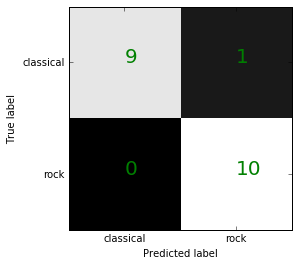

In [13]:
fig, ax = plt.subplots()
ax.imshow(cm, interpolation='nearest', cmap='gray')
for i, line in enumerate(cm):
    for j, l in enumerate(line):
        ax.text(j, i, l, size=20, color='green')
ax.set_xticks(range(len(cm)))
ax.set_xticklabels(labels)
ax.set_yticks(range(len(cm)))
ax.set_yticklabels(labels)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
plt.show()

Since in this example we have 2 classes (labels), the confusion matrix is 2x2. Furthermore, the confusions are fairly obvious, classical can only be confused with rock, and rock can only be confused with classical. However, when working on a multiclass problem (i.e. when there are more than 2 classes), the confusion matrix can be much more informative, as it tells us how much each class is confused with every other class. This can help us identify particularly problematic classes that are confused often, and help us figure out how to improve the model: are the classes well represented by the training data or do we need more data? Are the features that we're using sufficient for distinguishing between these classes, or do we need more/different features?

<h3>Qualitative analysis</h3>

By now we know how accurate our model is (on the test data), and how many files of each class get confused with another class. But we still don't know WHY the model made the specific mistakes that it did. Is it a limittation of the model? Is it because of the features we use? Perhaps it's the data itself? Answering this is a hard but necessary question. Sometimes we can try to figure this out quantitatively, but often we'll have to take a more qualitative approach.

Let's start by listing the missclassified files and what they were classified as:

In [14]:
# Print results
index = 0
for filename, prediction, label in zip(test_files, predictions, test_labels):
    if prediction != label:
        print "{:d} {:s} is {:s} but was classified as {:s}".format(
            index, os.path.basename(filename), labels[label], labels[prediction])
    index += 1

7 classical_Nessun Dorma.mp3.wav is classical but was classified as rock


Since our data is audio, we can listen to it!

In [15]:
audio_err, _ = librosa.load(test_files[7], sr=samplerate)

In [16]:
Audio(audio_err, rate=samplerate)

With any luck, through listening to some of the errors we can try to identify why they were missclassified. In this example the dataset is so small that the mistakes are likely due to the limited amount of data available to train the model.